# 1D fluid model of HET

Using the Fluid code of Roberto (ex Trevor's) in order to study some stuffs with it

In [1]:
# %matplotlib inline

import matplotlib.pyplot as plt
import random
import string
import pickle
import sys
import numpy as np
from multiprocessing import Pool, current_process

from tqdm import tqdm_notebook as tqdm

In [2]:

sys.path.append("../LPP1D//LPP1D")
from model import Model, OperatingConditions, NumericalConditions
from diagnostics import init_figure, plot_figure

def random_string(string_length):
    """Generate a random string with the combination of lowercase and uppercase letters """
    letters = string.ascii_letters
    return ''.join(random.choice(letters) for _ in range(string_length))

def self_tqdm(x, *args, **kwargs):
    return x



In [3]:
def simulate_once_ud(ud=250, ignore_RLC = True):
    """Simulate once, and return the data_file name and the data"""
    opC = OperatingConditions()
    nmC = NumericalConditions()
    
    opC.Tt = 1e-3  # secondes

    opC.L = 5e-2  # m
    opC.L0 = 4e-2  # m
    opC.L1 = 4.9e-2  # m
    opC.Capacitor = 6e-6

    nmC.NG = 201
    M = Model(opC=opC, nmC=nmC, ignore_RLC=ignore_RLC, self_tqdm=self_tqdm)
    #M = Model(opC=opC, nmC=nmC, ignore_RLC=ignore_RLC)

    M.init_simulation()

    # First, run with the usual parameters in order to get the steady state
    print("\r Running first simulation ..."+str(ud), end="")
    M.run_simulation()
    
    
    M.init_compteur_and_diags()
    M.opC.V0 = ud     # V
    M.opC.Tt = 4e-3  # secondes

    M.V = ud
    M.circuit_RLC.V0 = ud
    print("\r Running 2nd simulation ..."+str(ud), end="")

    M.run_simulation()
    print("\r Simulation DONE           ", end="\n")

    #M.post_proc_simulation()

    data_file_name = random_string(20)

    #with open("data_stored/"+data_file_name+".dat", "wb") as f:
    #    pickle.dump([M.Nt, M.data_stor, M.circuit_RLC.R,
    #                 M.circuit_RLC.L, M.circuit_RLC.C,
    #                 ud, M.circuit_RLC.ignore], f)
    return data_file_name, M.data_stor

# Run the simulations

Here, we solve for a few discharge tension 

In [4]:
save_figs = False

In [5]:
ud_list = [215, 220, 225, 230, 235,240, 245,250, 255, 260, 262, 265, 267, 270, 273, 275, 277, 280, 285]
#ud_list = [200, 207, 215,  220, 225, 230, 240, 250]
#ud_list = [220, 225, 230]

# No RLC circuit

In [6]:
def simulate_noRLC(ud):
    return simulate_once_ud(ud, True)

In [7]:
import pickle

filename = "./results_example_Bokeh.dat"

In [8]:
%%time
run_parallele = True
run_the_simulations = False

if run_the_simulations : 
    if run_parallele:
        "Use multi processing to //ize the parametric study"
        pool = Pool(len(ud_list))
        results_ud_noRLC = list(pool.map(simulate_noRLC, ud_list))
        pool.close()
    else:
        results_ud_noRLC = list(map(simulate_noRLC, ud_list))
        


    with open(filename, "wb") as f:
        pickle.dump([ud_list, results_ud_noRLC], f)

else :
    with open(filename, "rb") as f:
        ud_list, results_ud_noRLC = pickle.load( f)

CPU times: user 143 ms, sys: 53.8 ms, total: 197 ms
Wall time: 198 ms


## Quick visualisation

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


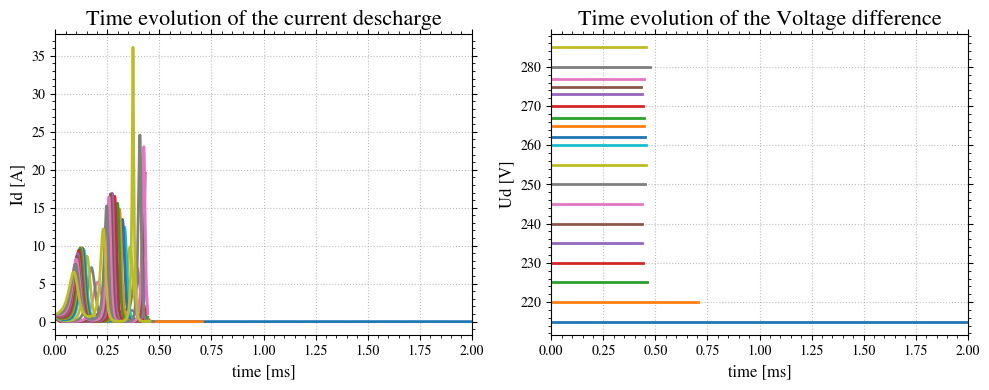

In [9]:
plt.style.use("presentation")
plt.figure(figsize=(10,4))
plt.subplot(121)

for (name, data), ud in zip(results_ud_noRLC, ud_list):
    time, current, tension = [data[k] for k in ["Time", "Id", "Ud"]]
    if np.abs(current[-1]) < 1e14:
        plt.plot(time, current, label="Ud = "+str(ud)+" V")


plt.title("Time evolution of the current descharge")
plt.xlabel("time [ms]")
plt.ylabel("Id [A]")
plt.xlim(0, 2)


plt.subplot(122)

for (name, data), ud in zip(results_ud_noRLC, ud_list):
    time, current, tension = [data[k] for k in ["Time", "Id", "Ud"]]
    if current[-1] < 1e2:
        plt.plot(time, tension,label="Ud = "+str(ud)+" V")
#plt.legend()
plt.xlim(0, 2)

plt.title("Time evolution of the Voltage difference")
plt.xlabel("time [ms]")
plt.ylabel("Ud [V]")

plt.tight_layout()
if save_figs:
    plt.savefig("Id_t_ud.png")

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


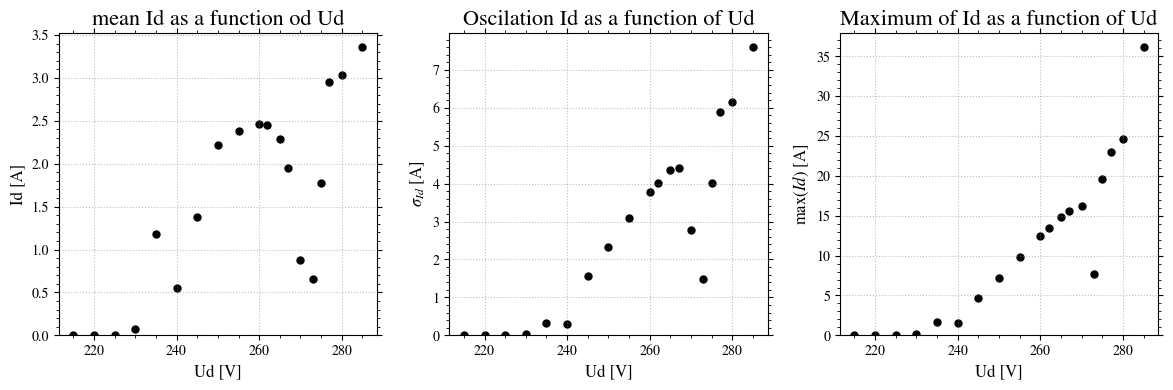

In [10]:
plt.figure(figsize=(12,4))

plt.subplot(131)

for (name, data), ud in zip(results_ud_noRLC, ud_list):
    time, current, tension = [data[k] for k in ["Time", "Id", "Ud"]]
    if current[-1] < 1e2:
        plt.scatter(ud, current[len(time)//3*2:].mean(), c='k')
        
plt.title("mean Id as a function od Ud")
plt.xlabel("Ud [V]")
plt.ylabel("Id [A]")
plt.ylim(0)
#if save_figs:
#    plt.savefig("Id_ud.png")

plt.subplot(132)
for (name, data), ud in zip(results_ud_noRLC, ud_list):
    time, current, tension = [data[k] for k in ["Time", "Id", "Ud"]]
    if current[-1] < 1e2:
        plt.scatter(ud, current[len(time)//3*2:].std(), c='k')
        
plt.title("Oscilation Id as a function of Ud")
plt.xlabel("Ud [V]")
plt.ylabel("$\\sigma_{Id}$ [A]")
plt.ylim(0)


plt.subplot(133)
for (name, data), ud in zip(results_ud_noRLC, ud_list):
    time, current, tension = [data[k] for k in ["Time", "Id", "Ud"]]
    if current[-1] < 1e2:
        plt.scatter(ud, current[len(time)//3*2:].max(), c='k')
        
plt.title("Maximum of Id as a function of Ud")
plt.xlabel("Ud [V]")
plt.ylabel("max$(Id)$ [A]")
plt.ylim(0)

plt.tight_layout()

if save_figs:
    plt.savefig("Idosc_ud.png")

# Interactive Vizualisation

In [11]:
randomname, A = results_ud_noRLC[0]
A.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [12]:
x, ng, ni, vi, Phi, Enorm, Te, t, I = A[0]

In [13]:
len(A[0])

9

In [14]:
from bokeh.io import output_notebook, output_file, push_notebook

from bokeh.layouts import gridplot, layout, Spacer
from bokeh.layouts import column, row
from bokeh.models import CustomJS, Slider, TapTool, Span, Range1d
from bokeh.plotting import ColumnDataSource, figure, output_file, show, save

from bokeh.models import Span
from bokeh.models.glyphs import Text
from ipywidgets import interact

output_notebook()

Loading BokehJS ...

In [15]:

def timestep_to_dict(data, timestep=0):
    x, ng, ni, vi, Phi, Enorm, Te, t, I = data[timestep]
    return { "x": x, "ng":ng, "ni":ni, "vi":vi, "phi":Phi, "E":Enorm, "Te":Te, "y":ng }


In [16]:
ub_index = 7
randomname, A = results_ud_noRLC[ub_index]

B = {"Time":A["Time"], "Id": A["Id"], "Ud":A["Ud"], "Te":A["Te"]}
    
source = ColumnDataSource(data= timestep_to_dict(A, 0))

sourc_temporals = ColumnDataSource(data=B)

title_texts = {"ng": "Neutral Gaz density (Xe)",
             "ni":"Plasma density ",
             "vi":"Ion velocity",
             "phi": "Electrostatic potential",
             "E": "Electric field",
             "Te":"Electron temperature"}
ylabel_texts = {"ng": "ng [m⁻³]",
             "ni":"ni, ne [m⁻³]",
             "vi":"Ion velocity",
             "phi": "Electrostatic potential",
             "E": "Electric field",
             "Te":"Electron temperature"}

In [17]:


plot = figure( plot_width=850,
              plot_height=500,
              toolbar_location="below",
              toolbar_sticky=False,
              tools= "crosshair,pan,wheel_zoom,box_zoom,save,reset",
             background_fill_color="#fafafa")

# configure so that no drag tools are active
plot.toolbar.active_drag = None


plot.title.text = title_texts["ng"]  + f", t = {B['Time'][0]*1e3:2.2f} ms"

plot.xaxis.axis_label = "Position [cm]"
plot.yaxis.axis_label = ylabel_texts['ng']


line_ng = plot.line('x', 'y',
          source=source,
          line_width=3,
          line_alpha=0.9,
          line_color="black")

handle = show(plot, notebook_handle=True)

def update_time(toplot, timestep=0):
    line_ng.data_source.data = timestep_to_dict(A, int(timestep))
    line_ng.data_source.data["y"] = line_ng.data_source.data[toplot]
    
    plot.title.text =  title_texts[toplot] + f", t = {B['Time'][timestep]*1e3:2.2f} ms"
    
    push_notebook(handle=handle)
    
interact(update_time, toplot = ["ng", "ni", "phi"], timestep=(0, len(B["Time"])-1, 1))





interactive(children=(Dropdown(description='toplot', options=('ng', 'ni', 'phi'), value='ng'), IntSlider(value…

<function __main__.update_time(toplot, timestep=0)>

In [18]:
ub_index = 7
ud = 0
randomname, A = results_ud_noRLC[ub_index]

B = {"Time":A["Time"], "Id": A["Id"], "Ud":A["Ud"], "Te":A["Te"]}
sourc_temporals = ColumnDataSource(data=B)

plot_space = figure( plot_width=400,
              plot_height=500,
              toolbar_location="left",
              toolbar_sticky=False,
              tools= "crosshair,pan,wheel_zoom,box_zoom,save,reset",
             background_fill_color="#fafafa")

# configure so that no drag tools are active
plot_space.toolbar.active_drag = None

data_to_plot = "ng"
timestep_plotted = 0

plot_space.title.text = title_texts[data_to_plot]  + f", t = {B['Time'][timestep_plotted]*1e3:2.2f} ms"

plot_space.xaxis.axis_label = "Position [cm]"
plot_space.yaxis.axis_label = ylabel_texts[data_to_plot]


profile_ng = plot_space.line('x', 'y',
          source=source,
          line_width=3,
          line_alpha=0.9,
          line_color="black")




In [19]:
plot_time = figure( plot_width=400,
              plot_height=250,
              toolbar_location="right",
              toolbar_sticky=False,
              tools= "crosshair,pan,wheel_zoom,box_zoom,save,reset",
             background_fill_color="#fafafa")


temporal_id = plot_time.line('Time', 'Id',
          source=sourc_temporals,
          line_width=3,
          line_alpha=0.9,
          line_color="black")

current_time_line = Span(location=B['Time'][timestep_plotted],
                         dimension='height',
                         line_color='red',
                         line_width=2,
                         line_dash="dashed")
plot_time.renderers.extend([current_time_line])

plot_time.xaxis.axis_label = "time [mus]"
plot_time.yaxis.axis_label = "Id [A]"



In [23]:

scatter_plot = figure( plot_width=400,
              plot_height=250,
              toolbar_location="right",
              toolbar_sticky=False,
              tools= "tap,reset",
             background_fill_color="#fafafa",
                     title="Click on a point !")
scatter_plot.xaxis.axis_label = "Ud [V]"
scatter_plot.yaxis.axis_label = "max(Id) [A]"

n_cases = len(results_ud_noRLC)

id_cases = [ r["Id"].max() for name, r in results_ud_noRLC]

scat_id = scatter_plot.circle(x=ud_list,
                              y=id_cases,
                              size=10)


plot_space.y_range=Range1d(-0.1, 1.2)

layout = row([plot_space, column([scatter_plot, plot_time])])
handle = show(layout, notebook_handle=True)




In [21]:
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown


In [24]:

def update_time(toplot, timestep=0):
    
    data_to_plot=toplot
    timestep_plotted = timestep
    
    ud_index = np.argmin(np.abs(np.array(ud_list) - ud ))
    print(ud_index)
    randomname, A = results_ud_noRLC[ud_index]

    B = {"Time":A["Time"], "Id": A["Id"], "Ud":A["Ud"], "Te":A["Te"]}

    profile_ng.data_source.data.update(timestep_to_dict(A, int(timestep)) )
    profile_ng.data_source.data["y"] = profile_ng.data_source.data[toplot]
    
    plot_space.title.text =  title_texts[toplot] + f", t = {B['Time'][timestep]*1e3:2.2f} ms"
    
    current_time_line.location = B['Time'][timestep_plotted]
    temporal_id.data_source.data.update( B)
    
    push_notebook(handle=handle)
    
timeslider = IntSlider(value=200,min=0, max=len(B["Time"])-1, step=1, )
varable_choice = Dropdown(options=["ng", "ni", "phi"], value="ng")
    
taptool = scatter_plot.select(dict(type=TapTool))[0]
taptool.callback = CustomJS(args=dict(scatter_plot=scatter_plot), code="""
        var d1 = cb_data.geometries.x;
        var kernel = IPython.notebook.kernel;
        kernel.execute("ud = " + d1);
        kernel.execute("update_time(varable_choice.value,timeslider.value) ");
        """
)

inter = interact(update_time, toplot =varable_choice , timestep=timeslider)


interactive(children=(Dropdown(description='toplot', options=('ng', 'ni', 'phi'), value='ng'), IntSlider(value…